how to measure the 2-point correlation function using DES data:

Download the DES galaxy catalog from the DES Data Lab.
Create a random catalog of galaxies with the same density as the real catalog.
Calculate the number of pairs of galaxies within a given angular separation for both the real and random catalogs.
Divide the number of real pairs by the number of random pairs to obtain the 2-point correlation function.


In [ ]:
import os
os.getcwd()

In [38]:
import astropy.io.fits as fits
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM

# Get the current user's home directory
home_dir = os.path.expanduser('~')

# Construct the path to the "Thesis" directory on the desktop
thesis_path = os.path.join(home_dir, 'Desktop', 'Thesis')

# Print the constructed path
print(thesis_path)

# Assuming you have the path to the FITS file stored in thesis_path
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  # Replace with your actual file name


/Users/otilia/Desktop/Thesis


In [39]:
t= Table.read(fits_file_path)
t  



id,ra,dec,fof_id,fof_size,mask_flags,flags,flagstr,badpix_frac,psf_g_0,psf_g_1,psf_T,bdf_T,bdf_T_err,bdf_T_ratio,bdf_g_0,bdf_g_1,bdf_fracdev,bdf_fracdev_err,tilename,EBV_SFD98,mask_flags_nir,flags_nir,flagstr_nir,badpix_frac_nir,psf_flux_u,psf_flux_g,psf_flux_r,psf_flux_i,psf_flux_z,psf_flux_J,psf_flux_H,psf_flux_Ks,psf_flux_err_u,psf_flux_err_g,psf_flux_err_r,psf_flux_err_i,psf_flux_err_z,psf_flux_err_J,psf_flux_err_H,psf_flux_err_Ks,bdf_flux_u,bdf_flux_g,bdf_flux_r,bdf_flux_i,bdf_flux_z,bdf_flux_J,bdf_flux_H,bdf_flux_Ks,bdf_flux_err_u,bdf_flux_err_g,bdf_flux_err_r,bdf_flux_err_i,bdf_flux_err_z,bdf_flux_err_J,bdf_flux_err_H,bdf_flux_err_Ks,gap_flux_u,gap_flux_g,gap_flux_r,gap_flux_i,gap_flux_z,gap_flux_J,gap_flux_H,gap_flux_Ks,gap_flux_err_u,gap_flux_err_g,gap_flux_err_r,gap_flux_err_i,gap_flux_err_z,gap_flux_err_J,gap_flux_err_H,gap_flux_err_Ks,psf_flux_calib_u,psf_flux_calib_g,psf_flux_calib_r,psf_flux_calib_i,psf_flux_calib_z,psf_flux_calib_J,psf_flux_calib_H,psf_flux_calib_Ks,psf_flux_err_calib_u,psf_flux_err_calib_g,psf_flux_err_calib_r,psf_flux_err_calib_i,psf_flux_err_calib_z,psf_flux_err_calib_J,psf_flux_err_calib_H,psf_flux_err_calib_Ks,bdf_flux_calib_u,bdf_flux_calib_g,bdf_flux_calib_r,bdf_flux_calib_i,bdf_flux_calib_z,bdf_flux_calib_J,bdf_flux_calib_H,bdf_flux_calib_Ks,bdf_flux_err_calib_u,bdf_flux_err_calib_g,bdf_flux_err_calib_r,bdf_flux_err_calib_i,bdf_flux_err_calib_z,bdf_flux_err_calib_J,bdf_flux_err_calib_H,bdf_flux_err_calib_Ks,psf_flux_dered_u,psf_flux_dered_g,psf_flux_dered_r,psf_flux_dered_i,psf_flux_dered_z,psf_flux_dered_J,psf_flux_dered_H,psf_flux_dered_Ks,psf_flux_err_dered_u,psf_flux_err_dered_g,psf_flux_err_dered_r,psf_flux_err_dered_i,psf_flux_err_dered_z,psf_flux_err_dered_J,psf_flux_err_dered_H,psf_flux_err_dered_Ks,bdf_flux_dered_u,bdf_flux_dered_g,bdf_flux_dered_r,bdf_flux_dered_i,bdf_flux_dered_z,bdf_flux_dered_J,bdf_flux_dered_H,bdf_flux_dered_Ks,bdf_flux_err_dered_u,bdf_flux_err_dered_g,bdf_flux_err_dered_r,bdf_flux_err_dered_i,bdf_flux_err_dered_z,bdf_flux_err_dered_J,bdf_flux_err_dered_H,bdf_flux_err_dered_Ks,psf_flux_dered_calib_u,psf_flux_dered_calib_g,psf_flux_dered_calib_r,psf_flux_dered_calib_i,psf_flux_dered_calib_z,psf_flux_dered_calib_J,psf_flux_dered_calib_H,psf_flux_dered_calib_Ks,psf_flux_err_dered_calib_u,psf_flux_err_dered_calib_g,psf_flux_err_dered_calib_r,psf_flux_err_dered_calib_i,psf_flux_err_dered_calib_z,psf_flux_err_dered_calib_J,psf_flux_err_dered_calib_H,psf_flux_err_dered_calib_Ks,bdf_flux_dered_calib_u,bdf_flux_dered_calib_g,bdf_flux_dered_calib_r,bdf_flux_dered_calib_i,bdf_flux_dered_calib_z,bdf_flux_dered_calib_J,bdf_flux_dered_calib_H,bdf_flux_dered_calib_Ks,bdf_flux_err_dered_calib_u,bdf_flux_err_dered_calib_g,bdf_flux_err_dered_calib_r,bdf_flux_err_dered_calib_i,bdf_flux_err_dered_calib_z,bdf_flux_err_dered_calib_J,bdf_flux_err_dered_calib_H,bdf_flux_err_dered_calib_Ks,psf_mag_u,psf_mag_g,psf_mag_r,psf_mag_i,psf_mag_z,psf_mag_J,psf_mag_H,psf_mag_Ks,psf_mag_dered_u,psf_mag_dered_g,psf_mag_dered_r,psf_mag_dered_i,psf_mag_dered_z,psf_mag_dered_J,psf_mag_dered_H,psf_mag_dered_Ks,psf_mag_err_dered_u,psf_mag_err_dered_g,psf_mag_err_dered_r,psf_mag_err_dered_i,psf_mag_err_dered_z,psf_mag_err_dered_J,psf_mag_err_dered_H,psf_mag_err_dered_Ks,psf_mag_dered_calib_u,psf_mag_dered_calib_g,psf_mag_dered_calib_r,psf_mag_dered_calib_i,psf_mag_dered_calib_z,psf_mag_dered_calib_J,psf_mag_dered_calib_H,psf_mag_dered_calib_Ks,bdf_mag_u,bdf_mag_g,bdf_mag_r,bdf_mag_i,bdf_mag_z,bdf_mag_J,bdf_mag_H,bdf_mag_Ks,bdf_mag_dered_u,bdf_mag_dered_g,bdf_mag_dered_r,bdf_mag_dered_i,bdf_mag_dered_z,bdf_mag_dered_J,bdf_mag_dered_H,bdf_mag_dered_Ks,bdf_mag_err_dered_u,bdf_mag_err_dered_g,bdf_mag_err_dered_r,bdf_mag_err_dered_i,bdf_mag_err_dered_z,bdf_mag_err_dered_J,bdf_mag_err_dered_H,bdf_mag_err_dered_Ks,bdf_mag_dered_calib_u,bdf_mag_dered_calib_g,bdf_mag_dered_calib_r,bdf_mag_dered_calib_i,bdf_mag_dered_calib_z,bdf_mag_dered_calib_J,bdf_mag_dered_calib_H,bdf_mag_dered_calib_Ks,kNN_class,z,SM
in

In [40]:
masked = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  # Replace with your actual file name

t3= Table.read(masked)
t3

id,ra,dec,fof_id,fof_size,mask_flags,flags,flagstr,badpix_frac,psf_g_0,psf_g_1,psf_T,bdf_T,bdf_T_err,bdf_T_ratio,bdf_g_0,bdf_g_1,bdf_fracdev,bdf_fracdev_err,tilename,EBV_SFD98,mask_flags_nir,flags_nir,flagstr_nir,badpix_frac_nir,psf_flux_u,psf_flux_g,psf_flux_r,psf_flux_i,psf_flux_z,psf_flux_J,psf_flux_H,psf_flux_Ks,psf_flux_err_u,psf_flux_err_g,psf_flux_err_r,psf_flux_err_i,psf_flux_err_z,psf_flux_err_J,psf_flux_err_H,psf_flux_err_Ks,bdf_flux_u,bdf_flux_g,bdf_flux_r,bdf_flux_i,bdf_flux_z,bdf_flux_J,bdf_flux_H,bdf_flux_Ks,bdf_flux_err_u,bdf_flux_err_g,bdf_flux_err_r,bdf_flux_err_i,bdf_flux_err_z,bdf_flux_err_J,bdf_flux_err_H,bdf_flux_err_Ks,gap_flux_u,gap_flux_g,gap_flux_r,gap_flux_i,gap_flux_z,gap_flux_J,gap_flux_H,gap_flux_Ks,gap_flux_err_u,gap_flux_err_g,gap_flux_err_r,gap_flux_err_i,gap_flux_err_z,gap_flux_err_J,gap_flux_err_H,gap_flux_err_Ks,psf_flux_calib_u,psf_flux_calib_g,psf_flux_calib_r,psf_flux_calib_i,psf_flux_calib_z,psf_flux_calib_J,psf_flux_calib_H,psf_flux_calib_Ks,psf_flux_err_calib_u,psf_flux_err_calib_g,psf_flux_err_calib_r,psf_flux_err_calib_i,psf_flux_err_calib_z,psf_flux_err_calib_J,psf_flux_err_calib_H,psf_flux_err_calib_Ks,bdf_flux_calib_u,bdf_flux_calib_g,bdf_flux_calib_r,bdf_flux_calib_i,bdf_flux_calib_z,bdf_flux_calib_J,bdf_flux_calib_H,bdf_flux_calib_Ks,bdf_flux_err_calib_u,bdf_flux_err_calib_g,bdf_flux_err_calib_r,bdf_flux_err_calib_i,bdf_flux_err_calib_z,bdf_flux_err_calib_J,bdf_flux_err_calib_H,bdf_flux_err_calib_Ks,psf_flux_dered_u,psf_flux_dered_g,psf_flux_dered_r,psf_flux_dered_i,psf_flux_dered_z,psf_flux_dered_J,psf_flux_dered_H,psf_flux_dered_Ks,psf_flux_err_dered_u,psf_flux_err_dered_g,psf_flux_err_dered_r,psf_flux_err_dered_i,psf_flux_err_dered_z,psf_flux_err_dered_J,psf_flux_err_dered_H,psf_flux_err_dered_Ks,bdf_flux_dered_u,bdf_flux_dered_g,bdf_flux_dered_r,bdf_flux_dered_i,bdf_flux_dered_z,bdf_flux_dered_J,bdf_flux_dered_H,bdf_flux_dered_Ks,bdf_flux_err_dered_u,bdf_flux_err_dered_g,bdf_flux_err_dered_r,bdf_flux_err_dered_i,bdf_flux_err_dered_z,bdf_flux_err_dered_J,bdf_flux_err_dered_H,bdf_flux_err_dered_Ks,psf_flux_dered_calib_u,psf_flux_dered_calib_g,psf_flux_dered_calib_r,psf_flux_dered_calib_i,psf_flux_dered_calib_z,psf_flux_dered_calib_J,psf_flux_dered_calib_H,psf_flux_dered_calib_Ks,psf_flux_err_dered_calib_u,psf_flux_err_dered_calib_g,psf_flux_err_dered_calib_r,psf_flux_err_dered_calib_i,psf_flux_err_dered_calib_z,psf_flux_err_dered_calib_J,psf_flux_err_dered_calib_H,psf_flux_err_dered_calib_Ks,bdf_flux_dered_calib_u,bdf_flux_dered_calib_g,bdf_flux_dered_calib_r,bdf_flux_dered_calib_i,bdf_flux_dered_calib_z,bdf_flux_dered_calib_J,bdf_flux_dered_calib_H,bdf_flux_dered_calib_Ks,bdf_flux_err_dered_calib_u,bdf_flux_err_dered_calib_g,bdf_flux_err_dered_calib_r,bdf_flux_err_dered_calib_i,bdf_flux_err_dered_calib_z,bdf_flux_err_dered_calib_J,bdf_flux_err_dered_calib_H,bdf_flux_err_dered_calib_Ks,psf_mag_u,psf_mag_g,psf_mag_r,psf_mag_i,psf_mag_z,psf_mag_J,psf_mag_H,psf_mag_Ks,psf_mag_dered_u,psf_mag_dered_g,psf_mag_dered_r,psf_mag_dered_i,psf_mag_dered_z,psf_mag_dered_J,psf_mag_dered_H,psf_mag_dered_Ks,psf_mag_err_dered_u,psf_mag_err_dered_g,psf_mag_err_dered_r,psf_mag_err_dered_i,psf_mag_err_dered_z,psf_mag_err_dered_J,psf_mag_err_dered_H,psf_mag_err_dered_Ks,psf_mag_dered_calib_u,psf_mag_dered_calib_g,psf_mag_dered_calib_r,psf_mag_dered_calib_i,psf_mag_dered_calib_z,psf_mag_dered_calib_J,psf_mag_dered_calib_H,psf_mag_dered_calib_Ks,bdf_mag_u,bdf_mag_g,bdf_mag_r,bdf_mag_i,bdf_mag_z,bdf_mag_J,bdf_mag_H,bdf_mag_Ks,bdf_mag_dered_u,bdf_mag_dered_g,bdf_mag_dered_r,bdf_mag_dered_i,bdf_mag_dered_z,bdf_mag_dered_J,bdf_mag_dered_H,bdf_mag_dered_Ks,bdf_mag_err_dered_u,bdf_mag_err_dered_g,bdf_mag_err_dered_r,bdf_mag_err_dered_i,bdf_mag_err_dered_z,bdf_mag_err_dered_J,bdf_mag_err_dered_H,bdf_mag_err_dered_Ks,bdf_mag_dered_calib_u,bdf_mag_dered_calib_g,bdf_mag_dered_calib_r,bdf_mag_dered_calib_i,bdf_mag_dered_calib_z,bdf_mag_dered_calib_J,bdf_mag_dered_calib_H,bdf_mag_dered_calib_Ks,kNN_class
int64,f

In [41]:
t=join(t,t3,keys='id')


t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')

In [42]:

# Access the columns directly
redshift = t['z']  # Access the 'z' column for redshift
declination = t['dec']  # Access the 'dec' column for declination
right_ascension = t['ra']  # Access the 'ra' column for right ascension

# Optional: explore or analyze the data
print(redshift.shape)  # Check the shape of the redshift array
print(f"Minimum redshift: {redshift.min()}")
print(f"Maximum redshift: {redshift.max()}")



(415091,)
Minimum redshift: 0.037304999999999984
Maximum redshift: 4.613163999999999


In [43]:
# Select redshift subset 
subset = (t['z'] > 0.6) & (t['z'] < 0.7) & (t['SM']>10.5)& (t['SM']<11)

# Extract right ascension (ra) and declination (dec) arrays from the subset
ra_subset = t['ra'][subset] #[::100]
dec_subset = t['dec'][subset]#[::100]

catalog=SkyCoord(ra=ra_subset*u.deg, dec=dec_subset*u.deg)

N = len(catalog)


def calculate_separations(cat, N):
    """Calculates the angular separation between all pairs of objects in a catalog.

    Args:
        catalog1: An astropy.coordinates.SkyCoord object containing object coordinates.
        N: The number of bins for the separation histogram.

    Returns:
        A numpy array of size N containing the counts of objects in each separation bin.
    """

    separation = cat.separation(cat[:, np.newaxis])

    return separation


In [44]:
def count_pairs_in_theta_bin(cat,theta_edges):
    """Counts the number of pairs of objects in a catalog that have an angular separation
    within a specified theta bin.

    Args:
        catalog: An astropy.coordinates.SkyCoord object containing object coordinates.
        theta_bins: A tuple defining the angular separation bin.

    Returns:
        The number of pairs within the theta bin.
    """
    separation = cat.separation(cat[:, np.newaxis]) 
    theta_hist,_= np.histogram(np.log10(separation.value),bins=theta_edges)

    #for i in range(0,N):
        #for j in range(i, N):
            #theta = calculate_separations(catalog[i],catalog[j])
            #theta_bins = calculate_separations(theta)
            
            #separation = catalog[i].separation(catalog[j]).to('deg').value
            #theta_bins = calculate_separations(SkyCoord(ra=ra_subset * u.deg, dec=dec_subset * u.deg), N=50)

            #theta_bins += 1

    return theta_hist


theta_edges=np.linspace(-2.5,0.25,50) #-2.5 and 0.25 are log of the max and min separation in degrees
dd_counts=count_pairs_in_theta_bin(catalog,theta_edges)  
print(dd_counts)

[   28    12    22    20    24    34    38    34    50    66   102   134
   152   172   236   248   360   420   508   588   748   948  1216  1502
  1848  2268  2958  3692  4342  5772  7554  9648 11864 14196 17522 21088
 26476 31398 37736 44654 53178 62694 72880 83102 88720 87172 73284 54380
 28074]


/var/folders/sm/7ys1bjcx13x_c71jgspgdldh0000gn/T/ipykernel_8561/4266226276.py:13: RuntimeWarning: divide by zero encountered in log10
  theta_hist,_= np.histogram(np.log10(separation.value),bins=theta_edges)


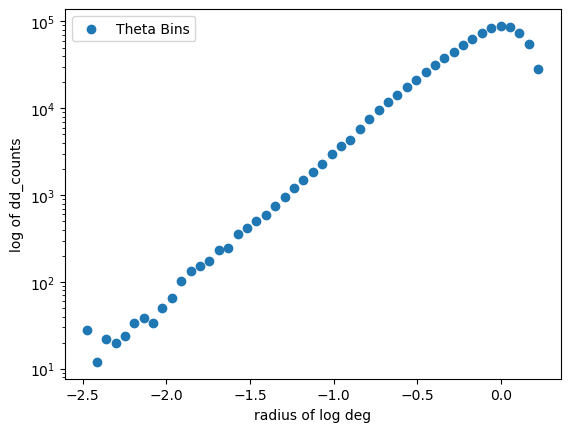

In [45]:
theta_edges=np.linspace(-2.5,0.25,50)

# bin centers
theta_cen= (theta_edges[:-1]+theta_edges[1:])/2

# Plot the theta bins
plt.scatter(theta_cen, dd_counts, label='Theta Bins')
plt.yscale('log')

# Set labels and title
plt.xlabel('radius of log deg')
plt.ylabel('log of dd_counts')
plt.title('')

# Show the plot
plt.legend()
plt.show()

In [46]:
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 

# Open the FITS file using astropy.io.fits
hdulist = fits.open(fits_random)
hdulist.info()

t2= Table.read(fits_random)
t2

Filename: /Users/otilia/Desktop/Thesis/SN-C3_randoms_ugriz_trim_video.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SN-C3_C01_randoms_raw.fits    1 BinTableHDU     18   13402307R x 3C   [E, E, 9A]   


ra,dec,Tilename
float32,float32,bytes9
52.4174,-27.207537,SN-C3_C01
52.449112,-27.199625,SN-C3_C01
52.263237,-27.225185,SN-C3_C01
52.363953,-27.128168,SN-C3_C01
52.19789,-27.176682,SN-C3_C01
52.369183,-27.188385,SN-C3_C01
...,...,...
53.090096,-29.023394,SN-C3_C62
53.002266,-28.988358,SN-C3_C62


In [47]:
# Extract right ascension (ra) and declination (dec) arrays from the subset
ra_2 = t2['ra'][::1000]
dec_2 = t2['dec'][::1000]




In [48]:
random_catalog=SkyCoord(ra=ra_2*u.deg, dec=dec_2*u.deg)



In [49]:
def calculate_2pcf(catalog, random_catalog, theta_edges):
    """Calculates the two-point correlation function (2PCF).

    Args:
        catalog: An astropy.coordinates.SkyCoord object containing data points.
        random_catalog: An astropy.coordinates.SkyCoord object containing random points.
        theta_cen: A numpy array defining the angular separation bin edges.

    Returns:
        A numpy array containing the 2PCF values for each theta bin.
    """

    # Calculate DD counts
    dd_counts = count_pairs_in_theta_bin(catalog, theta_edges)

    # Calculate RR counts
    rr_counts = count_pairs_in_theta_bin(random_catalog, theta_edges)
    
    #Normalise
    norma_dd= dd_counts/np.sum(dd_counts) 
    norma_rr= rr_counts/np.sum(rr_counts) 


    # Calculate 2PCF
    two_pcf = (norma_dd / norma_rr) - 1

    return two_pcf


theta_cen= (theta_edges[:-1]+theta_edges[1:])/2

two_pcf_result = calculate_2pcf(catalog, random_catalog, theta_edges)

print(two_pcf_result)



/var/folders/sm/7ys1bjcx13x_c71jgspgdldh0000gn/T/ipykernel_8561/4266226276.py:13: RuntimeWarning: divide by zero encountered in log10
  theta_hist,_= np.histogram(np.log10(separation.value),bins=theta_edges)


[ 4.34318251  0.69958568  1.49340229  0.68904348  0.72296375  0.76392553
  0.61340236  0.13933167  0.26051065  0.35829466  0.69566085  0.70514529
  0.55436677  0.36786077  0.52115603  0.25946074  0.44441264  0.32211923
  0.26312232  0.150602    0.15319764  0.15114122  0.16626245  0.13383351
  0.10490665  0.076893    0.11240659  0.10685071  0.04051824  0.10491505
  0.1144931   0.1020051   0.09986214  0.07067571  0.08472521  0.06841488
  0.08075606  0.06480137  0.08049011  0.05075073  0.03620803  0.0140921
 -0.00713994 -0.01831074 -0.03503002 -0.0311621  -0.08349272 -0.08065542
 -0.05306455]


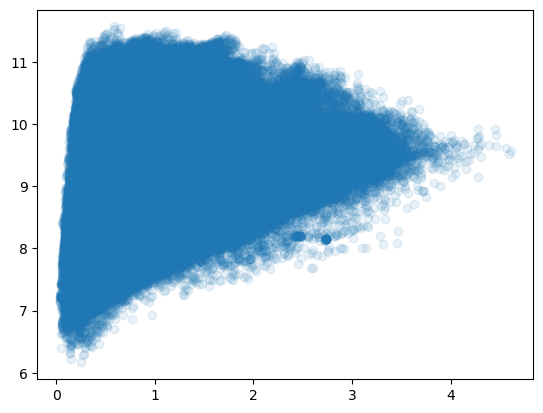

In [50]:
plt.scatter(t['z'],t['SM'],alpha=0.1)
plt.show()

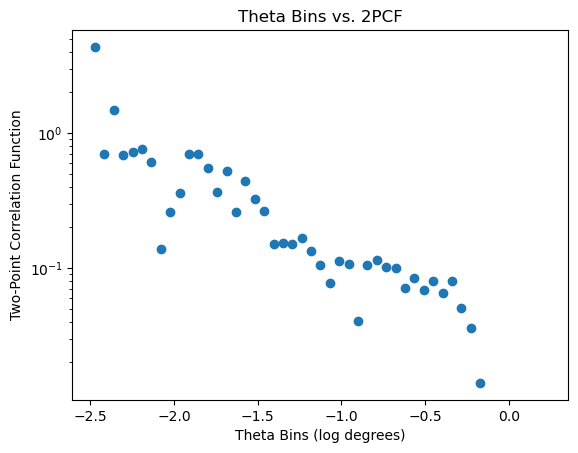

In [51]:
# Create the plot
plt.scatter(theta_cen, two_pcf_result)
plt.yscale('log')
# Set labels and title
plt.xlabel("Theta Bins (log degrees)")
plt.ylabel("Two-Point Correlation Function")
plt.title("Theta Bins vs. 2PCF")

# Show the plot
plt.show()

##### i added +2.5 to make the separation values bc else they have no sense?

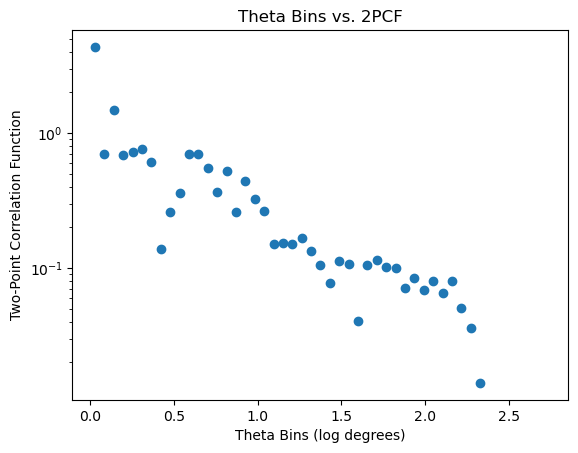

In [52]:
# Create the plot
plt.scatter(theta_cen+2.5, two_pcf_result)
plt.yscale('log')
# Set labels and title
plt.xlabel("Theta Bins (log degrees)")
plt.ylabel("Two-Point Correlation Function")
plt.title("Theta Bins vs. 2PCF")

# Show the plot
plt.show()

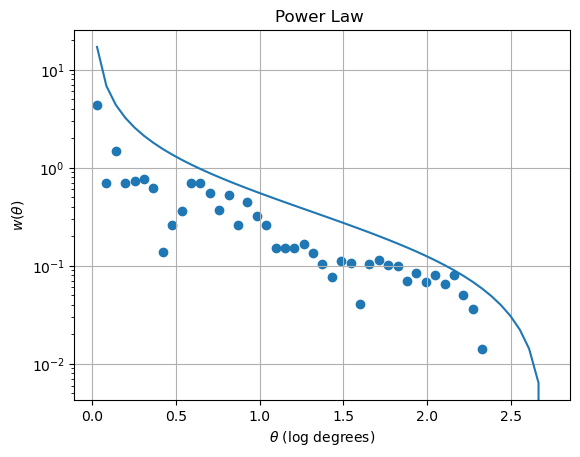

In [53]:
shifted_theta_cen = theta_cen + 2.5
fit= -0.45+shifted_theta_cen**(-0.8) #is HOD-predicted model. 

# Create the plot (log scale for y-axis)
plt.scatter(shifted_theta_cen, two_pcf_result) # two_pcf_result is w(theta)
plt.yscale('log')
plt.plot(shifted_theta_cen, fit, label='Power Law Fit')

# Set labels and title
plt.xlabel(r'$ \theta$ (log degrees)')
plt.ylabel( r'$w(\theta)$')
plt.yscale('log')
plt.title("Power Law ")
plt.grid(True)
plt.show()

## Integral constraint
Due to the relatively small volume probed by the survey, the integral constraint affects w(θ) at large scales. We adjust the model to take this into account. The correction factor due to the IC can be estimated from the double integration of the true correlation function over the survey area. This integration can be carried out using the random-random pairs from the random catalog following Roche & Eales (1999) where wtrue(θ) is HOD-predicted model. Finally, the model that we fit against the data is simply w(θ) = wtrue(θ) − wIC.


In [54]:
rr_counts = count_pairs_in_theta_bin(random_catalog, theta_edges) #theta_edges is log degrees
w_IC = two_pcf_result * rr_counts / np.sum(rr_counts) #IC = w(theta) * RR(theta) / SUM(RR)

print(w_IC)


 #Finally, the model that we fit against the data is simply w(θ) = wtrue(θ) − wIC.
w_model= two_pcf_result - w_IC
print(w_model)

/var/folders/sm/7ys1bjcx13x_c71jgspgdldh0000gn/T/ipykernel_8561/4266226276.py:13: RuntimeWarning: divide by zero encountered in log10
  theta_hist,_= np.histogram(np.log10(separation.value),bins=theta_edges)


[ 2.66456216e-05  5.78280897e-06  1.54264819e-05  9.55202712e-06
  1.17899340e-05  1.72388959e-05  1.69139914e-05  4.86786301e-06
  1.20978647e-05  2.03821520e-05  4.89912471e-05  6.48756576e-05
  6.34668624e-05  5.41539055e-05  9.46598387e-05  5.98133941e-05
  1.29675335e-04  1.19799518e-04  1.23889856e-04  9.01037119e-05
  1.16334809e-04  1.45721087e-04  2.02951007e-04  2.07560766e-04
  2.05418311e-04  1.89590707e-04  3.49934009e-04  4.17262924e-04
  1.97947689e-04  6.41645252e-04  9.08528747e-04  1.04552717e-03
  1.26111152e-03  1.09707916e-03  1.60227246e-03  1.58090495e-03
  2.31611213e-03  2.23705831e-03  3.29107186e-03  2.52500784e-03
  2.17545301e-03  1.01996212e-03 -6.13585260e-04 -1.81469287e-03
 -3.77057719e-03 -3.28255743e-03 -7.81594693e-03 -5.58539917e-03
 -1.84182395e-03]
[ 4.34315587  0.69957989  1.49338687  0.68903393  0.72295196  0.76390829
  0.61338545  0.1393268   0.26049855  0.35827428  0.69561186  0.70508042
  0.5543033   0.36780662  0.52106137  0.25940092  0.4442

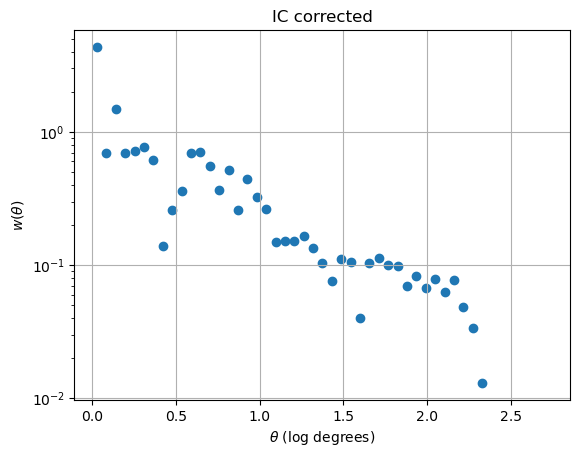

In [55]:
plt.scatter(shifted_theta_cen, w_model) # two_pcf_result is w(theta)
plt.yscale('log')
#plt.plot(shifted_theta_cen, fit, label='Power Law Fit')

plt.xlabel(r'$ \theta$ (log degrees)')
plt.ylabel( r'$w(\theta)$')
plt.yscale('log')
plt.title("IC corrected")
plt.grid(True)
plt.show()


## Implementing Gaussian Approximation for Errorbars

The Gaussian approximation to Poisson errors assumes that, for large counts, the Poisson distribution can be approximated by a normal distribution with mean and variance equal to the Poisson parameter 1  (in this case, the number of pairs). This approximation is reasonable when the number of pairs is sufficiently large.

In the Gaussian approximation, the fractional error is 1/sqrt(N pairs). We'll treat the RR part as being noiseless, and all the error as coming from Poisson error on the counting of DD pairs. So the errorbar on the ratio DD/RR is, ( 1 / sqrt(number of  DD pairs) ) * DD/RR

/var/folders/sm/7ys1bjcx13x_c71jgspgdldh0000gn/T/ipykernel_8561/4266226276.py:13: RuntimeWarning: divide by zero encountered in log10
  theta_hist,_= np.histogram(np.log10(separation.value),bins=theta_edges)


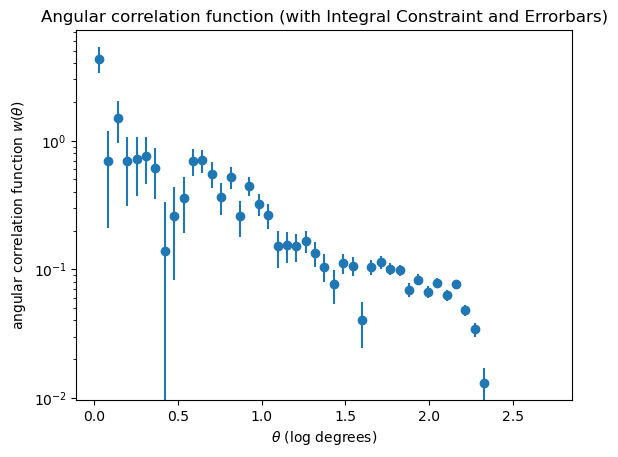

In [61]:
# Calculate DD counts
dd_counts = count_pairs_in_theta_bin(catalog, theta_edges)

# Calculate RR counts
rr_counts = count_pairs_in_theta_bin(random_catalog, theta_edges)
    
#Normalise
norma_dd= dd_counts/np.sum(dd_counts) 
norma_rr= rr_counts/np.sum(rr_counts) 

# Calculate 2PCF aka w(theta)= DD/RR - 1 
two_pcf = (norma_dd / norma_rr) - 1
    
fractional_error = 1 / np.sqrt(dd_counts)
errorbars = fractional_error * (norma_dd / norma_rr)  #So the errorbar on the ratio DD/RR is: ( 1 / sqrt(number of  DD pairs) ) * DD/RR

plt.errorbar(shifted_theta_cen, w_model, yerr=errorbars, fmt='o')
plt.yscale('log')
#plt.plot(shifted_theta_cen, fit, label='Power Law Fit')

plt.xlabel(r'$ \theta$ (log degrees)')
plt.ylabel( r'angular correlation function $w(\theta)$')
plt.yscale('log')
plt.title("Angular correlation function (with Integral Constraint and Errorbars)")
plt.show()

### See that despite the fact that the number of DD pairs is very high at large separations, the error on DD/RR - 1 is quite large. At small separations, the fact that there are few DD pairs leads to large errors too.

In [62]:
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=67.8, Om0=0.308)  # Replace with your cosmology parameters

theta_rad = 10**theta_cen #theta_cen * u.deg.to(u.rad)  # Convert log degrees to radians

# Calculate angular diameter distance (d_A)
d_A = cosmo.angular_diameter_distance(z=0.65)  # Average redshift 


# Convert theta from radians to Mpc
theta_Mpc = d_A * theta_rad

# Convert theta_Mpc to h^-1 Mpc
theta_h_inv_Mpc =  theta_Mpc / (cosmo.H0 * u.km / u.s / u.Mpc)


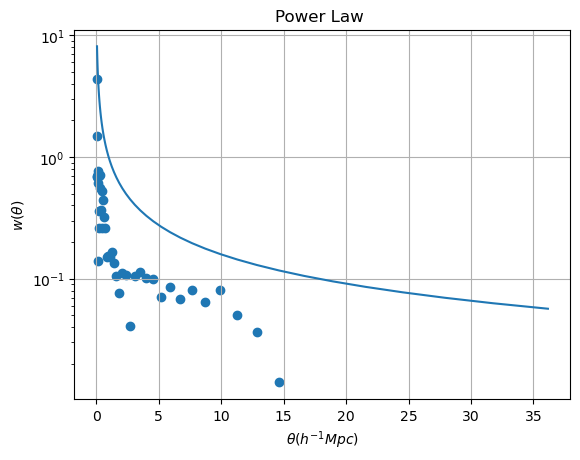

In [63]:

fit_mpc = theta_h_inv_Mpc ** (-0.8)
plt.yscale('log')
plt.plot(theta_h_inv_Mpc, fit_mpc, label='Power Law Fit')
plt.scatter(theta_h_inv_Mpc, two_pcf_result)

# Set labels and title
plt.xlabel(r'$ \theta(h^{-1} Mpc)$')
plt.ylabel( r'$w(\theta)$')
plt.yscale('log')
plt.title("Power Law ")
plt.grid(True)
plt.show()

## Adding a Power Law Fit to the 2-Point Correlation Function Plot

**Understanding the Power Law:**

In many cosmological scenarios, the 2-point correlation function of galaxies exhibits a power-law behavior at large scales. This means that the correlation function can be approximated by a function of the form:

```
ξ(r) = Ar^γ
```

where `ξ(r)` is the correlation function at separation `r`, `A` is a normalization constant, and `γ` is the power-law index.

Power-law fit parameters:
  r0: 0.09456230488728638
  gamma: -5.325621478251737


/var/folders/sm/7ys1bjcx13x_c71jgspgdldh0000gn/T/ipykernel_8561/2959447920.py:7: RuntimeWarning: invalid value encountered in power
  return (x / r0)**gamma


ZeroDivisionError: 0.0 cannot be raised to a negative power

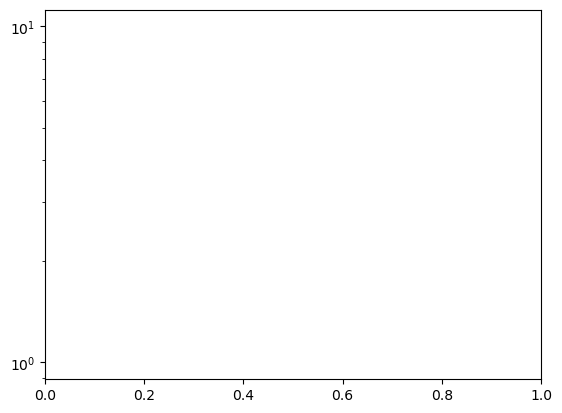

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Peebles & Groth (1975) power law function
def power_law(x, r0, gamma):
    return (x / r0)**gamma

# Fit the power law
popt, pcov = curve_fit(power_law, theta_h_inv_Mpc, two_pcf_result, p0=[5.0, -0.8])  # Initial guesses

# Print fit parameters
print("Power-law fit parameters:")
print("  r0:", popt[0])
print("  gamma:", popt[1])

# Create the plot (log scale for y-axis)
#plt.scatter(theta_cen, two_pcf_result)
plt.yscale('log')
plt.plot(theta_h_inv_Mpc, power_law(theta_h_inv_Mpc, *popt), label='Power Law Fit')

# Set labels and title
plt.xlabel(r'$ \theta(h^{-1} Mpc)$')
plt.ylabel( r'$w(\theta)$')
plt.yscale('log')
plt.title("Power Law ")
plt.show()

Power-law fit parameters:
  r0: 0.14905814445153243 h^-1 Mpc,
  gamma: -0.8557576364960974


/var/folders/sm/7ys1bjcx13x_c71jgspgdldh0000gn/T/ipykernel_8561/2959447920.py:7: RuntimeWarning: invalid value encountered in power
  return (x / r0)**gamma


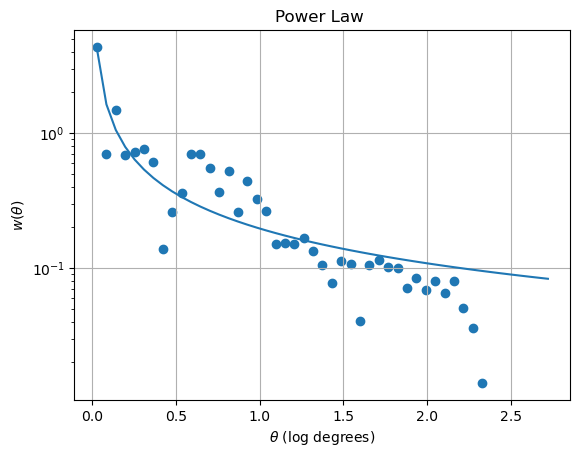

In [66]:

# Shift theta_cen by a constant value (2.5)
shifted_theta_cen = theta_cen + 2.5

# Fit the power law
popt, pcov = curve_fit(power_law, shifted_theta_cen, two_pcf_result, p0=[5.0, -0.8])  # Initial guesses


# Print fit parameters
print("Power-law fit parameters:")
print("  r0:", popt[0], "h^-1 Mpc,")
print("  gamma:", popt[1])

# Create the plot (log scale for y-axis)
plt.scatter(shifted_theta_cen, two_pcf_result)
plt.yscale('log')
plt.plot(shifted_theta_cen, power_law(shifted_theta_cen, *popt), label='Power Law Fit')

# Set labels and title
plt.xlabel(r'$ \theta$ (log degrees)')
plt.ylabel( r'$w(\theta)$')
plt.yscale('log')
plt.title("Power Law ")
plt.grid(True)
plt.show()

fit power law and slope of -0.8
integral constraint, check in papers